In [6]:
!pip3 install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/25/92/ee1d7a00bb6b8c55755d4984fd82608603a3cc59959245068ce32e7fb808/scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/61/d8/84da3fffefb6c7d5a16968fe5b9f24c98606b165bb801bb0b8bc3985200f/scipy-1.15.2-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.

## OPTICS Algorithm Implementation

In [24]:
# Add Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS as SklearnOPTICS
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score, adjusted_mutual_info_score, mutual_info_score
from collections import deque
import heapq
from common.functions import compute_gower_distance, visualize_clusters, compute_gower_distance_matrix

### Load Datasets

In [17]:
dataset_path = "./../datasets"

iris_dataset_path = dataset_path + "/iris.csv"                                         
ai_global_index_path = dataset_path + "/AI_index_db.csv"
global_earthquake_data_path = dataset_path + "/earthquakes.csv"

In [18]:
iris_df = pd.read_csv(iris_dataset_path)
ai_global_index_df = pd.read_csv(ai_global_index_path)
global_earthquake_data_df = pd.read_csv(global_earthquake_data_path)

iris_df = iris_df.drop(columns=['species'])


ai_global_index_df = ai_global_index_df.drop(columns=['Country', 'Cluster'])

ai_global_index_categorical_cols = ['Income group', 'Political regime', 'Region']
ai_global_index_numerical_cols = [
    "Talent", 
    "Infrastructure", 
    "Operating Environment", 
    "Research", 
    "Development", 
    "Government Strategy", 
    "Commercial", 
    "Total score"
]

income_order = {'Lower middle': 0, 'Upper middle': 1, 'High': 2}
ai_global_index_df['Income group'] = ai_global_index_df['Income group'].map(income_order)
# ai_global_index_df = pd.get_dummies(ai_global_index_df, columns=ai_global_index_categorical_cols)

earthquake_drop_cols = [
    'id', 'title', 'date', 'time', 'updated', 'url', 'detailUrl', 
    'ids', 'sources', 'types', 'place', 'placeOnly', 'location', 
    'what3words', 'locationDetails'
]
global_earthquake_data_df = global_earthquake_data_df.drop(columns=earthquake_drop_cols)


earthquake_categorical_cols = [
    'type', 'alert', 'status', 'net', 'magType', 'geometryType',
    'continent', 'country', 'subnational', 'city', 'locality', 'postcode', 'timezone'
]
earthquake_numerical_cols = [
    "magnitude", "felt", "cdi", "mmi", "tsunami", "sig",
    "nst", "dmin", "rms", "gap", "depth", "latitude",
    "longitude", "distanceKM"
]
global_earthquake_data_df[earthquake_categorical_cols] = global_earthquake_data_df[earthquake_categorical_cols]
# global_earthquake_data_df = pd.get_dummies(global_earthquake_data_df, columns=earthquake_categorical_cols)

datasets = {
    "iris": iris_df,
    "ai_global_index": ai_global_index_df,
    "global_earthquake": global_earthquake_data_df
}

### OPTICS Implementation (Based on our Algorithm - see report/Part-1.pdf)

In [19]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def find_neighbors(X, idx, eps):
    """
    Returns indices of all points in X that are within eps distance of X[idx].
    """
    distances = np.linalg.norm(X - X[idx], axis=1)
    return np.where(distances <= eps)[0]

def core_distance(X, idx, eps, min_pts):
    """
    Returns the core distance of point X[idx] if the number of neighbors is at least min_pts.
    Otherwise, returns None.
    The core distance is defined as the distance to the min_pts-th nearest neighbor.
    """
    neighbors = find_neighbors(X, idx, eps)
    if len(neighbors) < min_pts:
        return None
    # Compute distances to all neighbors
    distances = np.linalg.norm(X[neighbors] - X[idx], axis=1)
    sorted_distances = np.sort(distances)
    # Assuming X[idx] is in neighbors (with distance 0), core distance is the min_pts-th value.
    return sorted_distances[min_pts - 1]

class CustomOPTICS:
    def __init__(self, eps=0.5, min_pts=5):
        self.eps = eps
        self.min_pts = min_pts
        # reachability distance for each point (initialized to infinity)
        self.reachability_ = None
        # ordered list of points (indices) after processing
        self.ordered_list_ = None

    def fit(self, X):
        n = X.shape[0]
        processed = np.zeros(n, dtype=bool)
        reachability = np.full(n, np.inf)  # np.inf represents UNDEFINED
        ordered_list = []  # will store the order in which points are processed

        for idx in range(n):
            if not processed[idx]:
                # Process the current unprocessed point
                neighbors = find_neighbors(X, idx, self.eps)
                processed[idx] = True
                ordered_list.append(idx)
                c_dist = core_distance(X, idx, self.eps, self.min_pts)
                if c_dist is not None:
                    # Create an empty priority queue (min-heap)
                    seeds = []
                    self._update(X, idx, neighbors, processed, reachability, seeds)
                    while seeds:
                        # Pop the point with the smallest reachability distance
                        r, current = heapq.heappop(seeds)
                        if processed[current]:
                            continue
                        processed[current] = True
                        ordered_list.append(current)
                        current_neighbors = find_neighbors(X, current, self.eps)
                        c_dist_current = core_distance(X, current, self.eps, self.min_pts)
                        if c_dist_current is not None:
                            self._update(X, current, current_neighbors, processed, reachability, seeds)

        self.reachability_ = reachability
        self.ordered_list_ = ordered_list
        return self

    def _update(self, X, idx, neighbors, processed, reachability, seeds):
        """
        For a given point idx, update the reachability distances of its unprocessed neighbors.
        """
        c_dist = core_distance(X, idx, self.eps, self.min_pts)
        if c_dist is None:
            return
        for j in neighbors:
            if not processed[j]:
                d = euclidean_distance(X[idx], X[j])
                new_reach = max(c_dist, d)
                if new_reach < reachability[j]:
                    reachability[j] = new_reach
                    heapq.heappush(seeds, (reachability[j], j))

    def fit_predict(self, X):
        """
        Processes the dataset X using OPTICS and returns:
          - ordered_list_: the order in which points were processed
          - reachability_: the reachability distances for each point
        """
        self.fit(X)
        return self.ordered_list_, self.reachability_

### Compare our algorithm with sklearn

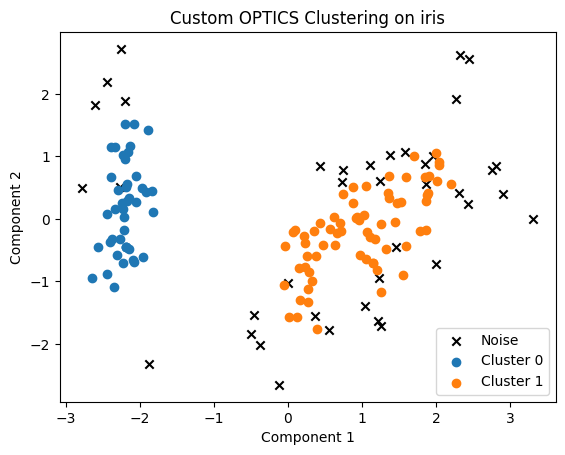

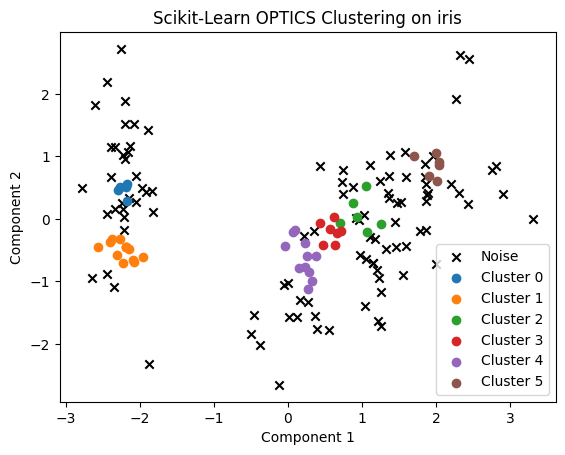

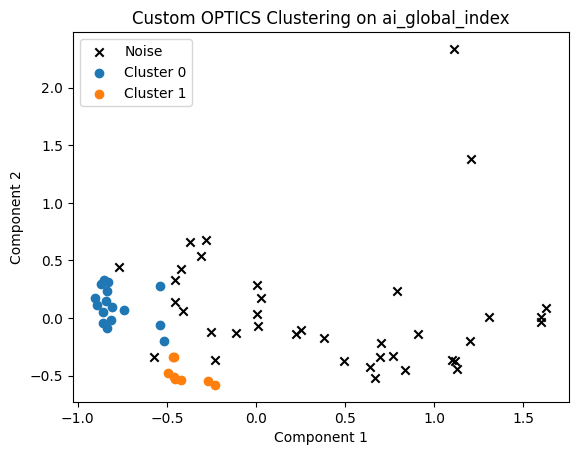

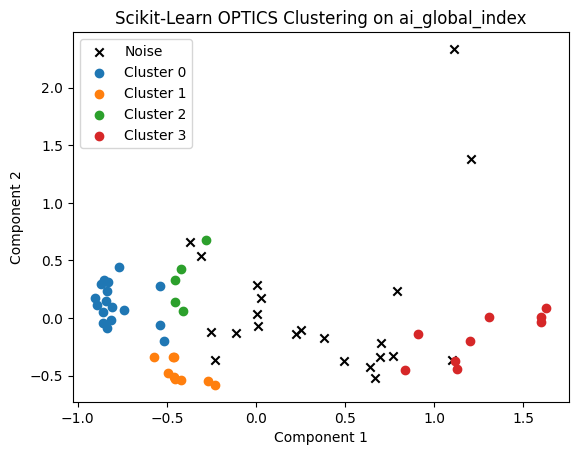

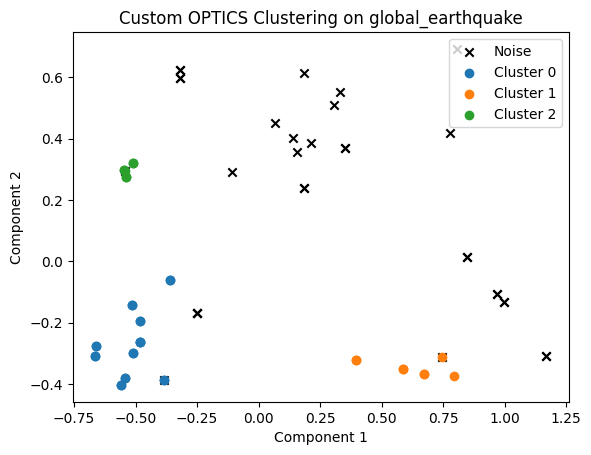

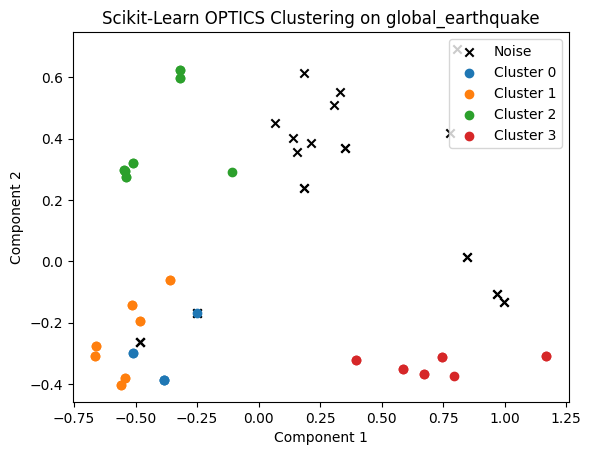

In [ ]:
def extract_clusters(order, reachability, threshold=0.5, min_cluster_size=5):
    """
    Extract clusters from OPTICS output.
    
    Points with reachability <= threshold are considered part of a cluster.
    A contiguous group of such points is only assigned a cluster label if it has 
    at least min_cluster_size points. Otherwise, those points are marked as noise (-1).
    """
    n = len(order)
    labels = np.full(n, -1, dtype=int)
    current_cluster = -1
    current_cluster_points = []
    
    for idx in order:
        if reachability[idx] <= threshold:
            # If we are not already in a cluster, start one
            if current_cluster == -1:
                current_cluster = 0 if np.all(labels == -1) else labels.max() + 1
                current_cluster_points = []
            current_cluster_points.append(idx)
            labels[idx] = current_cluster
        else:
            # Gap encountered: if the current cluster is too small, mark those points as noise
            if current_cluster != -1 and len(current_cluster_points) < min_cluster_size:
                for pt in current_cluster_points:
                    labels[pt] = -1
            # Reset for the next cluster
            current_cluster = -1
            current_cluster_points = []
            labels[idx] = -1  # mark this point as noise
    # Final check: if the last group is too small, mark as noise
    if current_cluster != -1 and len(current_cluster_points) < min_cluster_size:
        for pt in current_cluster_points:
            labels[pt] = -1
    return labels

results = []

for name, df in datasets.items():
    metric = None
    # Preprocessing:
    # For the iris dataset, remove the species column (assumed to be the last column)
    if name == "iris":
        # Remove species label (assumed to be the last column), drop NaNs, and standardize.
        X = df.dropna().values
        X = StandardScaler().fit_transform(X)
        metric = 'euclidean'
    elif name == "ai_global_index":
        # For AI Global Index: use mixed data. Drop NaNs and compute Gower distance.
        df_clean = df.dropna()
        X = compute_gower_distance_matrix(df_clean, num_cols=ai_global_index_numerical_cols, cat_cols=ai_global_index_categorical_cols)
        metric = 'precomputed'
    elif name == "global_earthquake":
        # For Global Earthquake: use mixed data. Drop NaNs and compute Gower distance.
        df_clean = df.dropna()
        X = compute_gower_distance_matrix(df_clean, num_cols=earthquake_numerical_cols, cat_cols=earthquake_categorical_cols)
        metric = 'precomputed'
    else:
        # For Global Earthquake: select numeric columns, drop NaNs, and standardize.
        X = df.select_dtypes(include=[np.number]).dropna().values
        X = StandardScaler().fit_transform(X)
        metric = 'euclidean'
    
    # ---------------------------
    # Custom OPTICS Implementation
    # ---------------------------
    custom_optics = CustomOPTICS(eps=0.5, min_pts=5)
    start_time = time.time()
    order, reachability = custom_optics.fit_predict(X)
    custom_runtime = time.time() - start_time
    # Extract clusters using a fixed threshold on reachability distances
    labels_custom = extract_clusters(order, reachability, threshold=0.5)
    custom_silhouette = (silhouette_score(X, labels_custom)
                         if len(set(labels_custom)) > 1 else None)
    results.append({
        "dataset": name,
        "type": "custom",
        "metric": metric,
        "silhouette": custom_silhouette,
        "runtime": custom_runtime,
        "cluster_count": len(set(labels_custom)) - (1 if -1 in labels_custom else 0),
        "noise_count": list(labels_custom).count(-1)
    })
    visualize_clusters(X=X, labels=labels_custom, title=f"Custom OPTICS Clustering on {name}", saveAs=f"{name}_optics_custom")

    # ---------------------------
    # Scikit-Learn OPTICS Implementation
    # ---------------------------
    start_time = time.time()
    # Note: For precomputed metrics, scikit-learn's OPTICS may not support 'precomputed' directly.
    # Here, we assume that for non-numeric data (e.g., Gower distances) we process similarly.
    if metric == 'precomputed':
        sklearn_optics = SklearnOPTICS(min_samples=5, max_eps=0.5, metric='precomputed')
    else:
        sklearn_optics = SklearnOPTICS(min_samples=5, max_eps=0.5)
    sklearn_optics.fit(X)
    labels_sklearn = sklearn_optics.labels_
    sklearn_runtime = time.time() - start_time
    sklearn_silhouette = (silhouette_score(X, labels_sklearn)
                          if len(set(labels_sklearn)) > 1 else None)
    results.append({
        "dataset": name,
        "type": "sklearn",
        "metric": metric,
        "silhouette": sklearn_silhouette,
        "runtime": sklearn_runtime,
        "cluster_count": len(set(labels_sklearn)) - (1 if -1 in labels_sklearn else 0),
        "noise_count": list(labels_sklearn).count(-1)
    })
    visualize_clusters(X=X, labels=labels_sklearn, title=f"Scikit-Learn OPTICS Clustering on {name}", saveAs=f"{name}_optics_sklearn")

# Save the results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv("optics_results.csv", index=False)